# Calculate-M-Values


A program designed to apply specific routine corrections (dark current, flatfield, registration) and calculate the coefficients used to unmix the data.  
Each time point is handled in a single matrix.  It is loaded into a single matrix in order with their channel number.  Thus, CH03 is image_data[3, :, :]


The data is collected as follows:
* 445: Camera 1 = 1_CH00 - mTurquoise
* 488: Camera 1 = 1_CH01 - EGFP
* 561: Camera 1 = 1_CH02
* 592: Camera 1 = 1_CH03
* 642: Camera 1 = 1_CH04
* 445: Camera 2 = 1_CH05
* 488: Camera 2 = 1_CH06 - EGFP Bleedthrough
* 561: Camera 2 = 1_CH07 - mOrange2
* 592: Camera 2 = 1_CH08
* 642: Camera 2 = 1_CH09



### Import modules


In [1]:
# Standard Library Imports
import os

# Third Party Imports
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm as tqdm

import pandas as pd

# Local Imports
import unmix_functions.file_processes as fp
import unmix_functions.background_correction as bc
import unmix_functions.registration_correction as rc
import unmix_functions.particle_detection as detect
import unmix_functions.data_analysis as da

### Specify the paths to load and save the data

In [2]:
registration_path = '/archive/MIL/dean/spectral_unmixing/image_corrections/registration'

median_background_path = '/archive/MIL/dean/spectral_unmixing/image_corrections/median_background_images'
raw_background_path = '/archive/MIL/dean/spectral_unmixing/image_corrections/background'

unmixing_matrix_path = '/archive/MIL/dean/spectral_unmixing/image_corrections'

labels = ['MNG-PAX', 'MOR-EB3', 'MTQ-VIM']
primary_channel = [1, 7, 0]
data_path = ['/archive/MIL/dean/spectral_unmixing/20200219_rawData/MNG-PAX/200218/movie', \
         '/archive/MIL/dean/spectral_unmixing/20200219_rawData/MOR-EB3/200218/movie', \
         '/archive/MIL/dean/spectral_unmixing/20200219_rawData/MTQ-VIM/200218/movie']
save_path = [s + '_results' for s in data_path]


data = {'Label': labels, 'data_path': data_path, 'save_path': save_path, 'primary_channel': primary_channel}
df = pd.DataFrame(data)
del(save_path, labels, data_path, data, primary_channel)
pd.options.display.max_columns = None
[rows, col] = df.shape
df.head(rows)


,Label,data_path,save_path,primary_channel
0,MNG-PAX,/archive/MIL/dean/spectral_unmixing/20200219_r...,/archive/MIL/dean/spectral_unmixing/20200219_r...,1
1,MOR-EB3,/archive/MIL/dean/spectral_unmixing/20200219_r...,/archive/MIL/dean/spectral_unmixing/20200219_r...,7
2,MTQ-VIM,/archive/MIL/dean/spectral_unmixing/20200219_r...,/archive/MIL/dean/spectral_unmixing/20200219_r...,0


### Calculate the Camera Registration and the RMS


In [3]:
ref_name = '1_CH00_000000.tif'
mov_name = '1_CH01_000000.tif'
method = 'AFFINE'
transform_object = rc.camera_registration_transform(registration_path, ref_name, mov_name, method)

Registering 1_CH00_000000.tif and 1_CH01_000000.tif
[[ 1.00187931e+00 -2.51863242e-04 -6.83473680e-02]
 [ 6.16643295e-04  1.00000793e+00 -8.41286657e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
RMS Before Registration = 48604.731307029724
RMS After Registration = 48334.02269268036


### Correct for:
* background
* flatfield
* perform image registration.

### Identify the features in each primary image channel with particle detection, etc.
* Steerable Filter for MTQ 
* Particle detection for PAX 
* Bandpass watershed approach for EB3


Processing MNG-PAX
Data Located: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MNG-PAX/200218/movie
Data Saved To: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MNG-PAX/200218/movie_results
There are 10.0 channels in this dataset.
There are 100.0 time points in this dataset.
All files are present
All Background Correction Files are Present



Processing MOR-EB3
Data Located: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MOR-EB3/200218/movie
Data Saved To: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MOR-EB3/200218/movie_results
There are 10.0 channels in this dataset.
There are 100.0 time points in this dataset.
All files are present
All Background Correction Files are Present



Processing MTQ-VIM
Data Located: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MTQ-VIM/200218/movie
Data Saved To: /archive/MIL/dean/spectral_unmixing/20200219_rawData/MTQ-VIM/200218/movie_results
There are 10.0 channels in this dataset.
There are 100.0 time points in this dataset.
All files are present
All Background Correction Files are Present


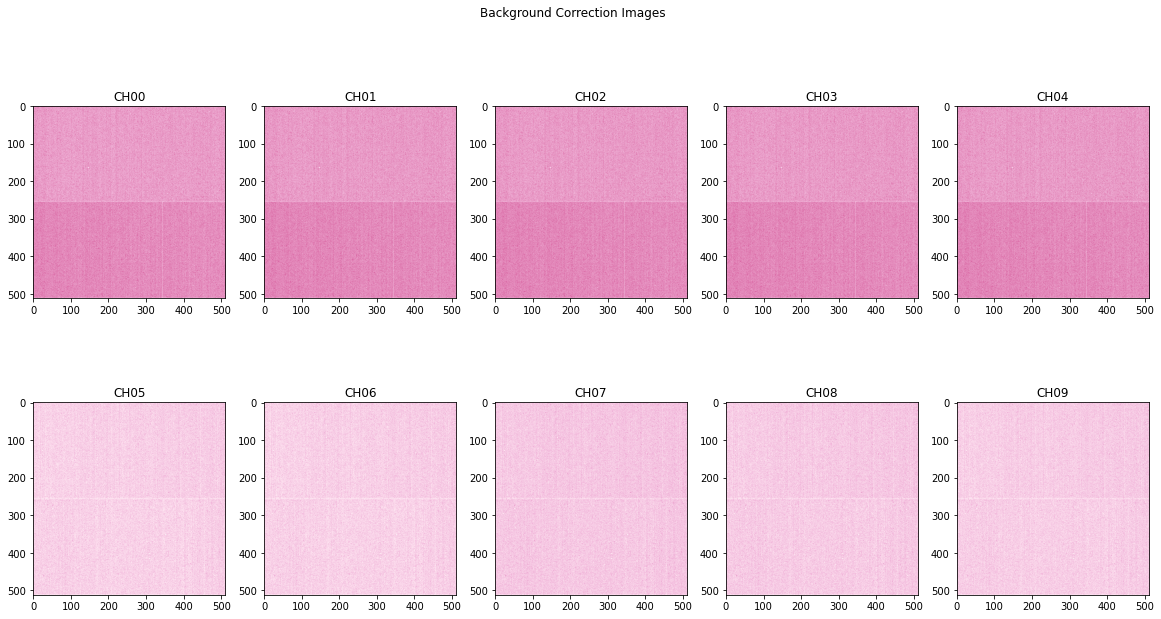

In [4]:
for index, row in df.iterrows():
    print("Processing " + row['Label'])
    print("Data Located: " + row['data_path'])
    print("Data Saved To: " + row['save_path'])
    
    if not os.path.isdir(row['save_path']):
        os.mkdir(row['save_path'])
    
    channel_number = fp.number_of_channels(row['data_path'])
    time_number = fp.number_of_timepoints(row['data_path'])
    fp.all_files_present(row['data_path'], channel_number, time_number)
    
    # Prepare or Load the Background Correction
    if bc.background_correction_complete(median_background_path, channel_number):
        background_correction = bc.load_prepared_background_correction(median_background_path, channel_number)
    else:
        bc.prepare_background_correction(raw_background_path, median_background_path)
        background_correction = bc.load_prepared_background_correction(median_background_path, channel_number)
    if index==0:
        bc.plot_background_correction_images(row['data_path'], channel_number, background_correction)
    
    # Apply the Data Corrections
    for t_idx in tqdm(range(int(time_number))):
        
        # Apply the Background Correction.
#        image_data = bc.background_correct_spectral_data(row['data_path'], channel_number, t_idx, background_correction)

        # Apply the Flatfield correction.

        # Register the Data
#        image_data = rc.transform_spectral_data(image_data, transform_object, channel_number)

        # Clean up the Data of zero value or saturated pixels.
#        image_data = bc.cleanup_spectral_data(image_data, channel_number)

        # Save the Data
#        fp.save_spectral_data(row['save_path'], image_data, channel_number, t_idx)
        
        if row['Label'] == 'MNG-PAX':
            high_frequency_cutoff = 3
            low_frequency_cutoff = 9
            step_size = 1
            image_threshold = 20
#            detect.watershed_bandpass(row['primary_channel'], t_idx, row['save_path'], high_frequency_cutoff, \
#                                          low_frequency_cutoff, step_size, image_threshold)

        elif row['Label'] == 'MOR-EB3':
            high_frequency_cutoff = 3
            low_frequency_cutoff = 9
            step_size = 1
            image_threshold = 20
#            detect.watershed_bandpass(row['primary_channel'], t_idx, row['save_path'], high_frequency_cutoff, \
#                                          low_frequency_cutoff, step_size, image_threshold)
        elif row['Label'] == 'MTQ-VIM':
            probability_threshold = 0.95
            #detect.mask_by_probability_map(row['primary_channel'], t_idx, row['save_path'], probability_threshold)

        else:
            print('Label detection method not specified')

### Calculate Crosstalk Values from Single Label Cells

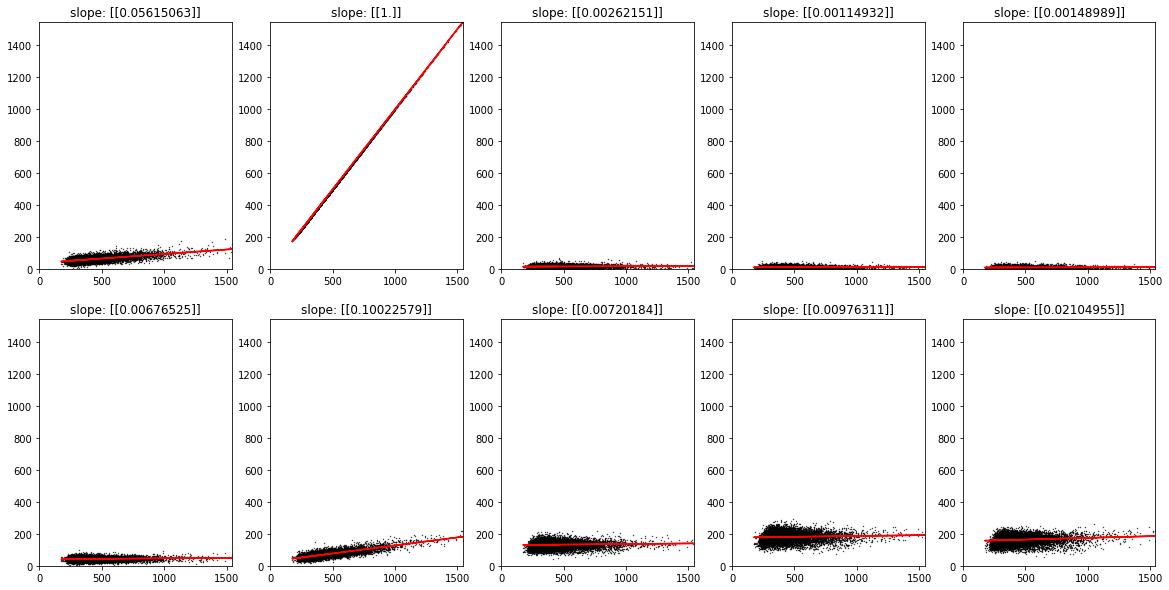

<Figure size 432x288 with 0 Axes>

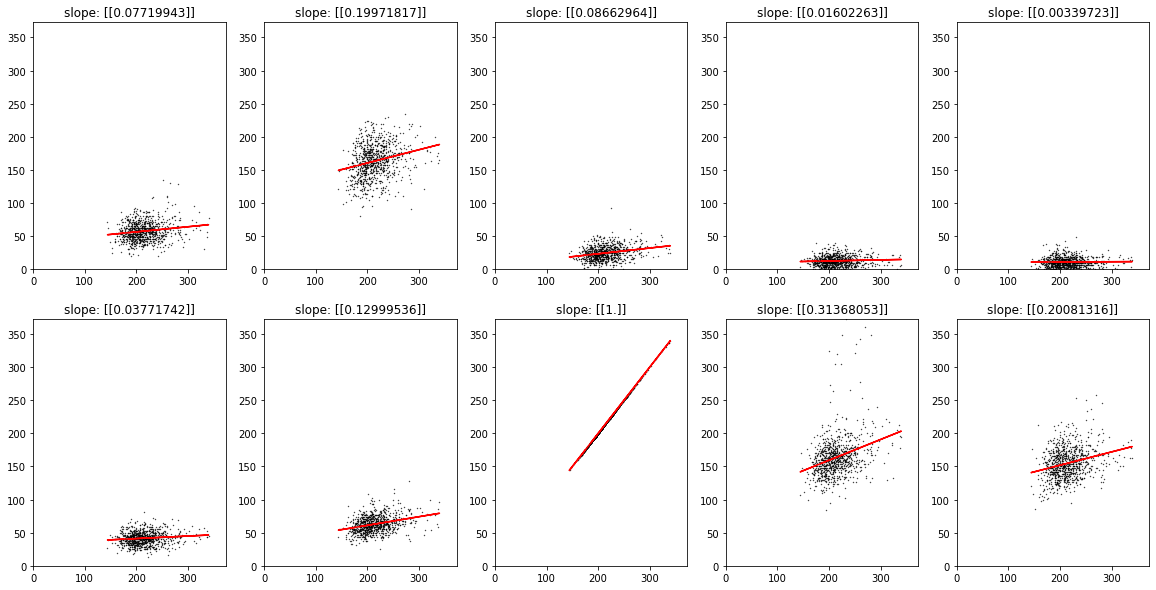

<Figure size 432x288 with 0 Axes>

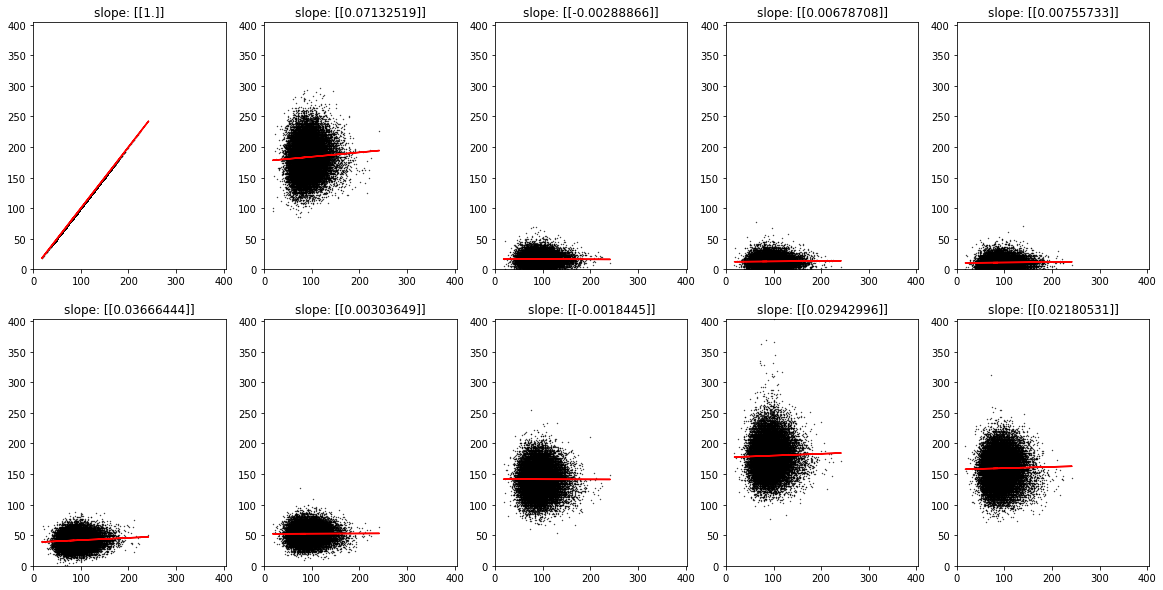

,MNG-PAX,MOR-EB3,MTQ-VIM
0,0.056151,0.077199,1.000000
1,1.000000,0.199718,0.071325
2,0.002622,0.086630,-0.002889
3,0.001149,0.016023,0.006787
4,0.001490,0.003397,0.007557
5,0.006765,0.037717,0.036664
6,0.100226,0.129995,0.003036
7,0.007202,1.000000,-0.001844
8,0.009763,0.313681,0.029430
9,0.021050,0.200813,0.021805


<Figure size 432x288 with 0 Axes>

In [19]:
import unmix_functions.data_analysis as da
for index, row in df.iterrows():
    time_number = 100
    channel_number = 10
    # channels, channel_name, channel_number, time_number, data_path, test_subset=False
    intensity = da.measure_crosstalk(row['primary_channel'], row['Label'], channel_number, time_number, row['save_path'], test_subset=True)
    output_slopes = da.plot_crosstalk_scatterplots(row['primary_channel'], row['Label'], channel_number, intensity, row['save_path'])
    if index == 0:
        unmixing_matrix = {}
        unmixing_matrix[row['Label']] = output_slopes
    else:
        temp_matrix = {}
        temp_matrix[row['Label']] = output_slopes
        unmixing_matrix.update(temp_matrix)
        
unmixing_matrix = pd.DataFrame.from_dict(unmixing_matrix)
[rows, col] = unmixing_matrix.shape
unmixing_matrix.to_csv(os.path.join(unmixing_matrix_path, 'unmixing_matrix.csv'), index=False)
unmixing_matrix.head(rows)

# Unmix Multichannel Data

In [5]:
from multiprocessing import Pool
from tifffile import imread, imsave
from scipy.optimize import nnls
import numpy as np
import pandas as pd

multichannel_data_path = '/archive/MIL/dean/spectral_unmixing/20200219_rawData/3label-4pro/200218/movie'
multichannel_save_path = multichannel_data_path + '_results'
if not os.path.isdir(multichannel_save_path):
    os.mkdir(multichannel_save_path)

# Determine Number of Timepoints, Channels, and Confirm All Files Are Present
channel_number = fp.number_of_channels(multichannel_data_path)
time_number = fp.number_of_timepoints(multichannel_data_path)
fp.all_files_present(multichannel_data_path, channel_number, time_number)

# Specify Correction Files
median_background_path = '/archive/MIL/dean/spectral_unmixing/image_corrections/median_background_images'
unmixing_matrix_path = '/archive/MIL/dean/spectral_unmixing/image_corrections'

# Wrap the data into a single matrix that can be passed to Pools
image_info=[]
for i in range(int(time_number)):
    temp = [int(i), channel_number, multichannel_data_path, multichannel_save_path, median_background_path,transform_object, unmixing_matrix_path]
    if i == 0:
        image_info = np.array(temp)
    else:
        image_info = np.vstack((image_info, temp))

    
if __name__ == '__main__':
    with Pool(30) as p:
        p.map(da.unmix_data, image_info)
        print('done')

There are 10.0 channels in this dataset.
There are 100.0 time points in this dataset.
All files are present
done
